In [1]:
# All imports
import torch
import torch.multiprocessing as mp

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm, trange
import json

from utils import get_test_loader, test_network, update_sd_by_idx
from models import LeNet5, VGG, LSTM

In [3]:
mp.set_start_method('spawn') # needs to be done once for cuda

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
torch.set_default_device(device)

Using device: cuda


In [4]:
datasets = ['cifar10', 'mnist', 'airline']

# dictionary mapping (dataset) -> (model_class, num_iters, num_epochs)
nets = {
        'cifar10':    (VGG, 5, 300),  
        'mnist':   (LeNet5, 5, 100),
        'airline':  (LSTM, 5, 5000)
       }

In [40]:
# Plotting functions
def plot_acc_vs_epoch(all_accs):

  plt.figure()
  all_accs = np.array(all_accs)
  x = range(all_accs.shape[1])
  y = np.average(all_accs, axis=0)
  error = np.std(all_accs, axis=0)

  plt.plot(x, y, )
  plt.fill_between(x, y-error, y+error, alpha=0.2)

  plt.xlabel('Epoch (#)')
  plt.ylabel('Test Accuracy (%)')

  # Let's also log the avg. peak accuracies
  print(all_accs)
  peak_accs = np.max(all_accs, axis=1)
  avg_peaks, std_peaks = np.average(peak_accs), np.std(peak_accs)
  print(peak_accs)
  print(f'Dataset {dataset}: Acc (%) (Avg +- Std): {avg_peaks} +- {std_peaks}') 
  return avg_peaks, std_peaks

We have provided training checkpoints across multiple iterations, where each model is trained from scratch, on all investigated datasets. 

Let's now prepare testing accuracy data for each case.

We iterate over datasets, iterations, epochs, and record the testing performance of the model at each point in the process.

We also record the processed accuracy dataset, so that this step doesn't have to be repeated.

In [12]:
test_accs_all = {}
best_models_all = {}

skip_raw_processing = True

if (skip_raw_processing):
  with open('test_accs_all.json','r') as json_file:
    test_accs_all = json.load(json_file)
else:
  # Let's process the raw data
  for dataset in datasets[:1]:
    
    model_class, num_iters, num_epochs = nets[dataset]
    num_epochs = 2
    num_iters = 2
    model = model_class() # instantiate the network
    
    test_accs = np.zeros((num_iters, num_epochs))
    test_loader = get_test_loader(dataset, device=device)
    
    for i in range(num_iters):
      print(f'\nDataset: {dataset}, Model Iteration: {i}')
      for j in trange(num_epochs):
        
        # load the state dict from checkpoint
        old_state_dict = torch.load(f"model_checkpoints/{dataset}/{i}/statedict_epoch{j}.pt", weights_only=True)
        new_state_dict = model.state_dict()
        update_sd_by_idx(old_state_dict, new_state_dict)
        model.load_state_dict(new_state_dict)
    
        acc, _ = test_network(test_loader, model, device)
    
        # compute the test accuracy
        test_accs[i, j] = acc

    test_accs_all[dataset] = test_accs.tolist()

  # all datasets processed, let's save to avoid processing next time
  with open('test_accs_all.json','w') as fp:
      fp.write(json.dumps(test_accs_all))
    

[[10.14 35.18]
 [10.64 33.76]]
[35.18 33.76]
Dataset cifar10: Acc (%) (Avg +- Std): 34.47 +- 0.7100000000000009


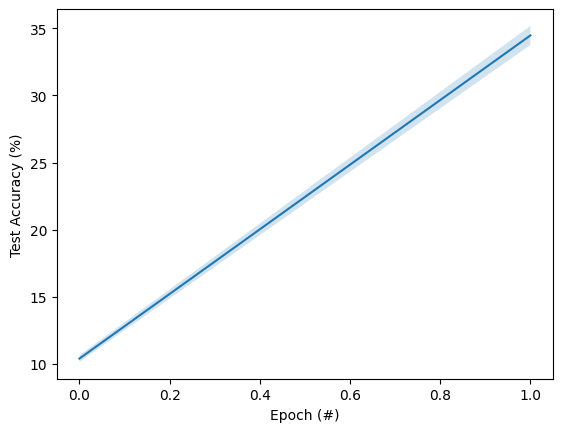

In [41]:
test_accs_all
for dataset in datasets[:1]:
  plot_acc_vs_epoch(test_accs_all[dataset])

plt.show()

In [13]:
test_accs_all

{'cifar10': [[10.14, 35.18], [10.64, 33.76]]}